## Running experiments with local resources w/ MLflow

In this example, all the compute and storage are local, and we are using MLflow to log the metrics of the experiment and serve that on Azure ML's URI.

In [1]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config()

print(f"Working in Azure workspace {ws.name} with version {azureml.core.VERSION}")

Working in Azure workspace azml-sdk with version 1.30.0


### Method 3: Running an experiment interactively with MLflow

MLflow is an alternative to the native log functions. It is a platform agnostic framework for end2end ML work flow. 

Starting experiment: diabetes-local-mlflow


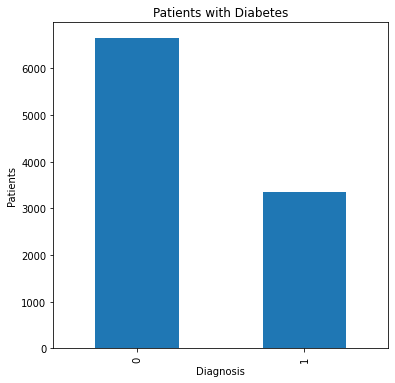

In [2]:
from azureml.core import Experiment
import pandas as pd
import mlflow
import os

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment = Experiment(workspace=ws, name="diabetes-local-mlflow")
mlflow.set_experiment(experiment.name)

with mlflow.start_run():
    print(f"Starting experiment: {experiment.name}")
    
    df = pd.read_csv("data/diabetes.csv")
    
    # Log some basic metrics
    row_count = df.shape[0]
    
    # Unlike AzureML's native logging functions, which append value to each metric, MLflow doesn't 
    # allow changing the value assigned to each key. Additionally, log_metric only supports float value
    mlflow.log_metric("observations", row_count)  # Log a number
    # Use log_param for other types of data that need to be logged
    mlflow.log_param("columns", df.columns)
    
    cat_cols = ["Pregnancies"]
    num_cols = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
    mlflow.log_param("categorical columns", cat_cols)
    mlflow.log_param("numerical columns", num_cols)

    # Log some image output
    import matplotlib.pyplot as plt

    diabetic_counts = df['Diabetic'].value_counts()

    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()    
    diabetic_counts.plot.bar(ax = ax) 
    ax.set_title('Patients with Diabetes') 
    ax.set_xlabel('Diagnosis') 
    ax.set_ylabel('Patients')
    
    mlflow.log_figure(fig, "img_log.png")  # Log an image

    # Log some file
    os.makedirs("outputs", exist_ok=True)
    df.sample(100).to_csv("outputs/sample.csv", index=False)
    
    mlflow.log_artifact("outputs/sample.csv")

My first impression is that that Azure ML has better support for its native logging functionalities, compared to MLflow. But MLflow is pretty good as well.

### Method 4: Running an experiment from script with MLflow

The last method of running an experiment is really identical to the previous one. We simply write the code into a `.py` file and submit it similar to what we do with the native logging method. The only difference is that we no longer need to specify the Workspace context. It's pretty amazing how MLflow can *just work* without us even  specifying the run context (like `Run.get_context()` with Azure native run).

Also, it logs the `outputs` folder automatically. I believe this is a feature of `ScriptRunConfig`

In [3]:
from azureml.core import Experiment, Environment, ScriptRunConfig
from azureml.core.conda_dependencies import CondaDependencies

# Set up python environment
basic_env = Environment("pandas-env")
basic_env.python.conda_dependencies = CondaDependencies.create(pip_packages=["pandas", "mlflow"])
basic_env.python.user_managed_dependencies = True

# Specify script and environment
script_config = ScriptRunConfig(
    source_directory="./diabetes-local-mlflow-experiment",
    script="diabetes_mlflow_experiment.py",
    environment=basic_env,
)

# Create experiment
experiment = Experiment(workspace=ws, name="diabetes-local-mlflow")

# Run experiment
run = experiment.submit(config=script_config)
run_details = run.wait_for_completion(show_output=False)